In [1]:
import numpy as np
import gym
import gym.spaces as spaces
import gym.envs as envs
import time
import matplotlib.pyplot as plt

In [2]:
# Adapted from https://github.com/openai/gym/blob/master/gym/envs/toy_text/nchain.py
# Customization to accomodate with the implementation
N = 5
env = gym.make('NChain-v0', n=N, large= 10, small = 2, slip = 0.2 )

env.nS = env.observation_space.n
env.nA = env.action_space.n

# P[state][action] = prob, reward, s_prime
env.P = np.zeros((env.nS, env.nA, env.nA, 3)) 
for s in range(env.nS):
    if s == env.nS - 1 :
        env.P[s][0] = [ [(1-env.slip), env.large, s], [env.slip, env.small, 0] ]
        env.P[s][1] = [ [env.slip, env.large, s], [1 - env.slip, env.small, 0] ]
        continue
    # Forward
    env.P[s][0] = [ [(1-env.slip), 0 if s < env.nS - 1 else env.large, s+1], [env.slip, env.small, 0] ]
    # Backward
    env.P[s][1] = [ [env.slip, 0 if s < env.nS - 1 else env.large, s+1], [1 - env.slip, env.small, 0] ]

### Helper functions

In [3]:
def map_actions(optimal_policy):
    policy = []
    for i in optimal_policy:
        if i == 0: # Forward
            policy.append('F')
        elif i == 1: # Backward
            policy.append('B')
    return policy

In [4]:
# Policy Analysis

def get_score(env, policy, max_timestep=200, episodes=1000):
    R = np.zeros((episodes, max_timestep))
    A = np.zeros((episodes, max_timestep))
    ended = 0
    reached = []
    for ep in range(episodes):
        s = env.reset()
        for i in range(max_timestep):
            a = policy[s]
            A[ep][i] = a
            s_prime, reward, _, _ = env.step(a)
            R[ep][i] = reward
            s = s_prime
        if env.large in R[ep]:
            ended += 1
            reached.append(ep)
    
    total_R = np.sum(R, axis=1)
    max_r = np.max(total_R)
    min_r = np.min(total_R)
    avg_r = np.mean(total_R)
    print("Number of episodes reached end = ", ended, " out of ", episodes, " episodes." )
    if len(reached) > 0:
        print("Max reward where episode reached end = ", np.max(total_R[reached]))
        print("Min reward where episode reached end = ", np.min(total_R[reached]))
    print("Max Reward = ", max_r)
    print("Avg Reward = ", avg_r)
    print("Min Reward = ", min_r)
    
    return R, A

### Value Iteration
- Procedure Value_Iteration(S,A,P,R,θ):
           Inputs
                     S is the set of all states
                     A is the set of all actions
                     P is state transition function specifying P(s'|s,a)
                     R is a reward function R(s,a,s')
                     θ a threshold, θ>0
           Output
                     π[S] approximately optimal policy
                    V[S] value function
           Local
                     real array Vk[S] is a sequence of value functions
                     action array π[S]
           assign V0[S] arbitrarily
           k ←0
           repeat
                     k ←k+1
                     for each state s do
                               Vk[s] = maxa ∑s' P(s'|s,a) (R(s,a,s')+ γVk-1[s'])
           until ∀s |Vk[s]-Vk-1[s]| < θ
           for each state s do
                     π[s] = argmaxa ∑s' P(s'|s,a) (R(s,a,s')+ γVk[s'])
           return π,Vk

In [5]:
def get_action_values(env, s, V, gamma=0.99):
    action_values = np.zeros(env.nA)
    
    for a in range(env.nA):
        for prob, reward, s_prime in env.P[s][a]:
            action_values[a] += prob * ( reward + gamma * V[int(s_prime)])
            
    return action_values

In [6]:
'''Value Iteration'''
def value_iteration(env, gamma = 0.999, max_iteration = 1000):
    # Initialise Utility Function
    V = np.zeros(env.nS)

    for i in range(max_iteration):
        prev_V = np.copy(V)

        #loop over all states
        for s in range(env.nS):
            action_values = get_action_values(env, s, prev_V, gamma)
            best_action_value = np.max(action_values)
            V[s] = best_action_value

        if i%10 == 0 and np.all(np.isclose(V, prev_V)):
            print("Value converged at iteration ", i)
            break

    optimal_policy = np.zeros(env.nS, dtype = 'int8')
    for s in range(env.nS):
        s_action_value = get_action_values(env, s, V, gamma)
        optimal_policy[s] = np.argmax(s_action_value)

    return V, optimal_policy

### Test Value Iteration 

Number of states:  2
Number of actions:  5
Value converged at iteration  4620
Time to converge:  4.02e+02 ms
Optimal Value function: 
[3627.62654429 3631.71026857 3636.82003369 3643.21363369 3651.21363369]
Final Policy: 
['F', 'F', 'F', 'F', 'F']


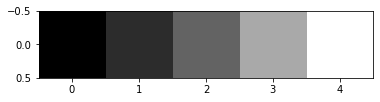

In [7]:
env.reset()
print("Number of states: ", env.action_space.n)
print("Number of actions: ", env.observation_space.n)

start_time = time.time()
optimal_value, optimal_policy = value_iteration(env, gamma=0.999, max_iteration=10000 )
stop_time = time.time()
time_taken = (stop_time - start_time)*1000

print (f"Time to converge: {time_taken : 0.3} ms")

print('Optimal Value function: ')
print(optimal_value)
plt.imshow(optimal_value.reshape(1,N), cmap='gray')

print('Final Policy: ')
policy = map_actions(optimal_policy)

print(policy)

In [8]:
R, A = get_score(env, optimal_policy, max_timestep=5, episodes=1000)

R, A = get_score(env, optimal_policy, max_timestep=10, episodes=1000)

R, A = get_score(env, optimal_policy, max_timestep=20, episodes=1000)

Number of episodes reached end =  320  out of  1000  episodes.
Max reward where episode reached end =  10.0
Min reward where episode reached end =  10.0
Max Reward =  10.0
Avg Reward =  5.204
Min Reward =  2.0
Number of episodes reached end =  660  out of  1000  episodes.
Max reward where episode reached end =  60.0
Min reward where episode reached end =  12.0
Max Reward =  60.0
Avg Reward =  23.6
Min Reward =  4.0
Number of episodes reached end =  919  out of  1000  episodes.
Max reward where episode reached end =  160.0
Min reward where episode reached end =  18.0
Max Reward =  160.0
Avg Reward =  60.236
Min Reward =  8.0


### Policy Iteration
The policy iteration algorithm manipulates the policy directly, rather than finding it indirectly via the optimal value function. It operates as follows:

<img src='http://incompleteideas.net/book/first/ebook/pseudotmp1.png'>
<img src='http://incompleteideas.net/book/first/ebook/imgtmp35.png'>

In [9]:
def get_policy_val(env, policy, V, gamma):
    policy_values = np.zeros(env.nS)
    for s, a in zip(range(len(policy)), policy):
        for prob, reward, s_prime in env.P[s][a]:
            policy_values[s] += prob * (reward + gamma * V[int(s_prime)])
            
    return policy_values

In [10]:
def policy_iteration(env, gamma = 0.99, max_iteration = 1000):
    V = np.zeros(env.nS)
    
    P = np.random.randint(0, env.nA, env.nS)
    prev_P = np.copy(P)
    
    for i in range(max_iteration):
        
        V = get_policy_val(env, P, V, gamma)
        
        for s in range(env.nS):
            s_action_value = get_action_values(env, s, V, gamma)
            P[s] = np.argmax(s_action_value)
        
        if i % 10 == 0:
            if np.all(np.equal(P, prev_P)):
                print("Policy converged at iteration ", i)
                break
            prev_P = np.copy(P)
        
    return V, P

### Testing Policy Iteration

Number of states:  2
Number of actions:  5
Policy converged at iteration  20
Time to converge:  3.16 ms
Optimal Value function: 
[64.71380396 68.79752825 73.90729337 80.30089337 88.30089337]
Final Policy: 
['F', 'F', 'F', 'F', 'F']


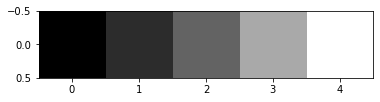

In [11]:
env.reset()
print("Number of states: ", env.action_space.n)
print("Number of actions: ", env.observation_space.n)

start_time = time.time()
optimal_value, optimal_policy = policy_iteration(env, gamma=0.999, max_iteration=1000)
stop_time = time.time()
time_taken = (stop_time - start_time)*1000

print (f"Time to converge: {time_taken : 0.3} ms")

print('Optimal Value function: ')
print(optimal_value)
plt.imshow(optimal_value.reshape((1, N)), cmap='gray')

print('Final Policy: ')
policy = map_actions(optimal_policy)

print(policy)

In [12]:
R, A = get_score(env, optimal_policy, max_timestep=5, episodes=1000)

R, A = get_score(env, optimal_policy, max_timestep=10, episodes=1000)

R, A = get_score(env, optimal_policy, max_timestep=20, episodes=1000)

Number of episodes reached end =  321  out of  1000  episodes.
Max reward where episode reached end =  10.0
Min reward where episode reached end =  10.0
Max Reward =  10.0
Avg Reward =  5.204
Min Reward =  2.0
Number of episodes reached end =  654  out of  1000  episodes.
Max reward where episode reached end =  60.0
Min reward where episode reached end =  12.0
Max Reward =  60.0
Avg Reward =  23.678
Min Reward =  4.0
Number of episodes reached end =  926  out of  1000  episodes.
Max reward where episode reached end =  160.0
Min reward where episode reached end =  16.0
Max Reward =  160.0
Avg Reward =  58.96
Min Reward =  8.0


## Q- Learning

In [13]:
import random
env.reset()
action_size = env.action_space.n
state_size = env.observation_space.n

qtable = np.zeros((state_size, action_size))
T = np.zeros((state_size, action_size, state_size))
T_Count = T.copy()
R = qtable.copy()

total_episodes = 100000       # Total episodes
learning_rate = 0.8           # Learning rate
max_steps = 99                # Max steps per episode
gamma = 0.95                  # Discounting rate

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.0001

In [14]:
# List of rewards
rewards = []

# 2 For life or until learning is stopped
for episode in range(total_episodes):
    # Reset the environment
    state = env.reset()
    step = 0
    done = False
    total_rewards = 0
    
    for step in range(max_steps):
        # 3. Choose an action a in the current world state (s)
        ## First we randomize a number
        exp_exp_tradeoff = random.uniform(0, 1)
        
        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state,:])

        # Else doing a random choice --> exploration
        else:
            action = env.action_space.sample()

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, info = env.step(action)

        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        # qtable[new_state,:] : all the actions we can take from new state
        qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])
                
        total_rewards += reward
        
        # Our new state is state
        state = new_state
        
        # If done (if we're dead) : finish episode
        if done == True: 
            break
        
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 
    rewards.append(total_rewards)

print ("Score over time: " +  str(sum(rewards)/total_episodes))
print(qtable)

Score over time: 189.8745
[[20.77464822 30.2851811 ]
 [33.16380003 21.33300923]
 [36.04462851 21.83521479]
 [36.36023094 22.39171522]
 [37.06470044 22.96625699]]


Optimal Value function: 
[30.285 33.164 36.045 36.36  37.065]
Final Policy: 
['B' 'F' 'F' 'F' 'F']


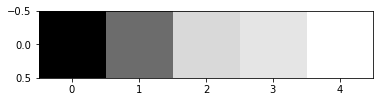

In [17]:
optimal_policy = np.argmax(qtable, axis=1)
optimal_value = np.amax(qtable, axis=1)

print('Optimal Value function: ')
print(np.round(optimal_value, 3))
plt.imshow(optimal_value.reshape((1, N)), cmap='gray')

print('Final Policy: ')
policy = map_actions(optimal_policy)

print(np.array(policy))

In [18]:
R, A = get_score(env, optimal_policy, max_timestep=5, episodes=1000)

R, A = get_score(env, optimal_policy, max_timestep=10, episodes=1000)

R, A = get_score(env, optimal_policy, max_timestep=20, episodes=1000)

Number of episodes reached end =  82  out of  1000  episodes.
Max reward where episode reached end =  10.0
Min reward where episode reached end =  10.0
Max Reward =  10.0
Avg Reward =  7.224
Min Reward =  2.0
Number of episodes reached end =  342  out of  1000  episodes.
Max reward where episode reached end =  60.0
Min reward where episode reached end =  12.0
Max Reward =  60.0
Avg Reward =  20.844
Min Reward =  4.0
Number of episodes reached end =  664  out of  1000  episodes.
Max reward where episode reached end =  160.0
Min reward where episode reached end =  22.0
Max Reward =  160.0
Avg Reward =  51.144
Min Reward =  16.0


In [19]:
import random
env.reset()
action_size = env.action_space.n
state_size = env.observation_space.n

qtable = np.zeros((state_size, action_size))
T = np.zeros((state_size, action_size, state_size))
T_Count = T.copy()
R = qtable.copy()

total_episodes = 100000       # Total episodes
learning_rate = 0.8           # Learning rate
max_steps = 99                # Max steps per episode
gamma = 0.95                  # Discounting rate

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.005

In [20]:
# List of rewards
rewards = []

# 2 For life or until learning is stopped
for episode in range(total_episodes):
    # Reset the environment
    state = env.reset()
    step = 0
    done = False
    total_rewards = 0
    
    for step in range(max_steps):
        # 3. Choose an action a in the current world state (s)
        ## First we randomize a number
        exp_exp_tradeoff = random.uniform(0, 1)
        
        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state,:])

        # Else doing a random choice --> exploration
        else:
            action = env.action_space.sample()

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, info = env.step(action)

        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        # qtable[new_state,:] : all the actions we can take from new state
        qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])
                
        total_rewards += reward
        
        # Our new state is state
        state = new_state
        
        # If done (if we're dead) : finish episode
        if done == True: 
            break
        
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 
    rewards.append(total_rewards)

print ("Score over time: " +  str(sum(rewards)/total_episodes))
print(qtable)

Score over time: 195.95084
[[23.51343068 24.99559788]
 [23.76599309 25.23384452]
 [24.10012463 24.80065067]
 [24.48045672 25.91289564]
 [34.23884721 23.55517845]]


Optimal Value function: 
[24.996 25.234 24.801 25.913 34.239]
Final Policy: 
['B' 'B' 'B' 'B' 'F']


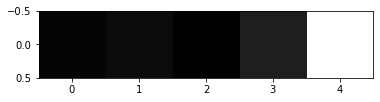

In [21]:
optimal_policy = np.argmax(qtable, axis=1)
optimal_value = np.amax(qtable, axis=1)

print('Optimal Value function: ')
print(np.round(optimal_value, 3))
plt.imshow(optimal_value.reshape((1, N)), cmap='gray')

print('Final Policy: ')
policy = map_actions(optimal_policy)

print(np.array(policy))

In [22]:
R, A = get_score(env, optimal_policy, max_timestep=5, episodes=1000)

R, A = get_score(env, optimal_policy, max_timestep=10, episodes=1000)

R, A = get_score(env, optimal_policy, max_timestep=20, episodes=1000)

Number of episodes reached end =  2  out of  1000  episodes.
Max reward where episode reached end =  10.0
Min reward where episode reached end =  10.0
Max Reward =  10.0
Avg Reward =  7.958
Min Reward =  2.0
Number of episodes reached end =  7  out of  1000  episodes.
Max reward where episode reached end =  44.0
Min reward where episode reached end =  16.0
Max Reward =  44.0
Avg Reward =  16.076
Min Reward =  8.0
Number of episodes reached end =  16  out of  1000  episodes.
Max reward where episode reached end =  128.0
Min reward where episode reached end =  30.0
Max Reward =  128.0
Avg Reward =  32.718
Min Reward =  22.0


In [23]:
import random
env.reset()
action_size = env.action_space.n
state_size = env.observation_space.n

qtable = np.zeros((state_size, action_size))
T = np.zeros((state_size, action_size, state_size))
T_Count = T.copy()
R = qtable.copy()

total_episodes = 100000       # Total episodes
learning_rate = 0.8           # Learning rate
max_steps = 99                # Max steps per episode
gamma = 0.95                  # Discounting rate

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.001

In [24]:
# List of rewards
rewards = []

# 2 For life or until learning is stopped
for episode in range(total_episodes):
    # Reset the environment
    state = env.reset()
    step = 0
    done = False
    total_rewards = 0
    
    for step in range(max_steps):
        # 3. Choose an action a in the current world state (s)
        ## First we randomize a number
        exp_exp_tradeoff = random.uniform(0, 1)
        
        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state,:])

        # Else doing a random choice --> exploration
        else:
            action = env.action_space.sample()

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, info = env.step(action)

        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        # qtable[new_state,:] : all the actions we can take from new state
        qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])
                
        total_rewards += reward
        
        # Our new state is state
        state = new_state
        
        # If done (if we're dead) : finish episode
        if done == True: 
            break
        
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 
    rewards.append(total_rewards)

print ("Score over time: " +  str(sum(rewards)/total_episodes))
print(qtable)

Score over time: 194.22406
[[24.84671367 24.96088044]
 [24.05420865 25.78158028]
 [27.96629565 24.50453178]
 [26.45767078 21.0294546 ]
 [29.66170942 24.29739073]]


Optimal Value function: 
[24.961 25.782 27.966 26.458 29.662]
Final Policy: 
['B' 'B' 'F' 'F' 'F']


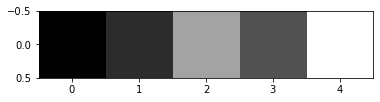

In [25]:
optimal_policy = np.argmax(qtable, axis=1)
optimal_value = np.amax(qtable, axis=1)

print('Optimal Value function: ')
print(np.round(optimal_value, 3))
plt.imshow(optimal_value.reshape((1, N)), cmap='gray')

print('Final Policy: ')
policy = map_actions(optimal_policy)

print(np.array(policy))

In [26]:
R, A = get_score(env, optimal_policy, max_timestep=5, episodes=1000)

R, A = get_score(env, optimal_policy, max_timestep=10, episodes=1000)

R, A = get_score(env, optimal_policy, max_timestep=20, episodes=1000)

Number of episodes reached end =  25  out of  1000  episodes.
Max reward where episode reached end =  10.0
Min reward where episode reached end =  10.0
Max Reward =  10.0
Avg Reward =  8.008
Min Reward =  2.0
Number of episodes reached end =  97  out of  1000  episodes.
Max reward where episode reached end =  60.0
Min reward where episode reached end =  16.0
Max Reward =  60.0
Avg Reward =  17.75
Min Reward =  6.0
Number of episodes reached end =  236  out of  1000  episodes.
Max reward where episode reached end =  144.0
Min reward where episode reached end =  26.0
Max Reward =  144.0
Avg Reward =  38.988
Min Reward =  20.0
